# Task 5: Logistic Map - Classical Chaos Comparison

## Objective

Apply the metaphor of an iterated map (logistic map) to analyze chaos in text generation and relate the observed phenomena to our text generation experiments.

This notebook compares:
- **Classical chaotic system**: Logistic map with $r = 4.0$ (maximum chaos)
- **Text generation system**: LLM outputs (analyzed previously)

---

## Theoretical Background

### The Logistic Map

The logistic map is one of the simplest examples of a deterministic chaotic system:

$$
x_{n+1} = r \cdot x_n (1 - x_n)
$$

where:
- $x_n \in [0, 1]$ represents the state at time $n$
- $r$ is the growth rate parameter

### Behavior by Parameter $r$:

| Range | Behavior |
|-------|----------|
| $0 < r < 1$ | Extinction (converges to 0) |
| $1 < r < 3$ | Stable fixed point |
| $3 < r < 3.57$ | Periodic oscillations (period doubling) |
| **$3.57 < r < 4$** | **Chaos** (sensitive dependence on IC) |
| **$r = 4$** | **Maximum chaos** (λ ≈ ln(2)) |

### Lyapunov Exponent

For the logistic map, the Lyapunov exponent measures the rate of exponential separation:

$$
\lambda = \lim_{N \to \infty} \frac{1}{N} \sum_{n=0}^{N-1} \ln |f'(x_n)|
$$

where $f'(x) = r(1 - 2x)$ is the derivative of the logistic map.

- $\lambda > 0$: Chaotic (exponential divergence)
- $\lambda = 0$: Neutral (linear or no divergence)
- $\lambda < 0$: Stable (convergence)

---

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
import Levenshtein

# Configure matplotlib for inline display
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

## 2. Logistic Map Implementation

We implement the core logistic map functions to generate trajectories and analyze their behavior.

In [3]:
def logistic_map(x: float, r: float) -> float:
    """
    Single iteration of the logistic map: x_{n+1} = r * x_n * (1 - x_n)
    
    Args:
        x: Current state in [0, 1]
        r: Growth rate parameter
    
    Returns:
        Next state x_{n+1}
    """
    return r * x * (1 - x)


def generate_trajectory(x0: float, r: float, n_steps: int) -> np.ndarray:
    """
    Generate a trajectory of the logistic map.
    
    This simulates the evolution of a dynamical system over time,
    analogous to generating a sequence of tokens in text generation.
    
    Args:
        x0: Initial condition (starting point)
        r: Growth rate parameter
        n_steps: Number of iterations (pseudo-time)
    
    Returns:
        Array of trajectory values
    """
    trajectory = np.zeros(n_steps)
    trajectory[0] = x0
    
    for i in range(1, n_steps):
        trajectory[i] = logistic_map(trajectory[i-1], r)
    
    return trajectory


# Test the implementation
print("Testing logistic map implementation:")
r_test = 4.0
x0_test = 0.5
traj_test = generate_trajectory(x0_test, r_test, 10)
print(f"First 10 values with r={r_test}, x0={x0_test}:")
print(traj_test)
print("Implementation successful")

Testing logistic map implementation:
First 10 values with r=4.0, x0=0.5:
[0.5 1.  0.  0.  0.  0.  0.  0.  0.  0. ]
Implementation successful


## 3. Divergence Analysis Functions

These functions calculate how two trajectories with slightly different initial conditions diverge over time.

This is the **key experiment** for detecting chaos: if tiny perturbations grow exponentially, the system is chaotic.

In [4]:
def calculate_trajectory_divergence(x0_1: float, x0_2: float, r: float, n_steps: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Calculate divergence between two trajectories with nearby initial conditions.
    
    This is analogous to our text generation experiment where we had:
    - Seed 1: "...driven by high-dimensional priors."
    - Seed 2: "...governed by high-dimensional priors."
    
    Args:
        x0_1: First initial condition
        x0_2: Second initial condition (slightly perturbed)
        r: Growth rate parameter
        n_steps: Number of time steps
    
    Returns:
        time_steps: Array of time indices
        divergence: Absolute difference |x1(n) - x2(n)|
        traj1: First trajectory
        traj2: Second trajectory
    """
    traj1 = generate_trajectory(x0_1, r, n_steps)
    traj2 = generate_trajectory(x0_2, r, n_steps)
    
    # Calculate absolute divergence at each time step
    divergence = np.abs(traj1 - traj2)
    time_steps = np.arange(n_steps)
    
    return time_steps, divergence, traj1, traj2

## 4. Lyapunov Exponent Calculation

We calculate the Lyapunov exponent in two ways:

1. **Analytical method**: Using the derivative of the logistic map
2. **Empirical method**: Fitting exponential growth to divergence data

In [5]:
def calculate_lyapunov_analytical(trajectory: np.ndarray, r: float) -> float:
    """
    Calculate Lyapunov exponent using the analytical formula.
    
    For the logistic map:
    λ = lim (1/N) Σ ln|f'(x_n)| where f'(x) = r(1 - 2x)
    
    This measures the average exponential rate of separation along the trajectory.
    
    Args:
        trajectory: Array of trajectory values
        r: Growth rate parameter
    
    Returns:
        Lyapunov exponent λ
    """
    # Derivative of logistic map: f'(x) = r(1 - 2x)
    derivatives = r * (1 - 2 * trajectory)
    
    # Take log of absolute values
    log_derivatives = np.log(np.abs(derivatives))
    
    # Average over trajectory (skip first few transient points)
    with np.errstate(divide='ignore', invalid='ignore'):
        lyapunov = np.mean(log_derivatives[100:])
    
    return lyapunov


def calculate_lyapunov_empirical(divergence: np.ndarray, n_fit_points: int = 20) -> float:
    """
    Calculate Lyapunov exponent empirically from divergence data.
    
    If d(n) = d(0) * exp(λ * n), then:
    ln(d(n)) = ln(d(0)) + λ * n
    
    We fit a line to ln(d(n)) vs n to extract λ as the slope.
    
    Args:
        divergence: Array of divergence values
        n_fit_points: Number of initial points to fit (before saturation)
    
    Returns:
        Empirical Lyapunov exponent λ
    """
    # Find first non-zero point
    nonzero_idx = np.where(divergence > 1e-10)[0]
    if len(nonzero_idx) == 0:
        return 0.0
    
    start_idx = nonzero_idx[0]
    end_idx = min(start_idx + n_fit_points, len(divergence))
    
    # Linear fit on log(divergence)
    time_range = np.arange(start_idx, end_idx)
    log_div = np.log(divergence[start_idx:end_idx])
    
    # Fit: log(d) = a + λ*t, where λ is the slope
    coeffs = np.polyfit(time_range, log_div, 1)
    lambda_empirical = coeffs[0]
    
    return lambda_empirical

## 5. Experiment: Logistic Map Chaos Analysis

Now we run the key experiment: generate two trajectories with **tiny** difference in initial conditions and observe how they diverge.

In [6]:
print("="*70)
print("LOGISTIC MAP CHAOS ANALYSIS")
print("="*70)

# Parameters
r = 4.0  # Maximum chaos
x0_1 = 0.5
x0_2 = 0.5 + 1e-6  # Tiny perturbation (0.0002%)
n_steps = 500

print(f"\nExperimental Setup:")
print(f"  Growth rate: r = {r} (chaotic regime)")
print(f"  Initial condition 1: x0_1 = {x0_1}")
print(f"  Initial condition 2: x0_2 = {x0_2}")
print(f"  Perturbation: {x0_2 - x0_1:.2e} ({(x0_2 - x0_1)/x0_1 * 100:.4e}%)")
print(f"  Time steps: {n_steps}")

# Generate trajectories
print(f"\nGenerating trajectories...")
time_steps, divergence, traj1, traj2 = calculate_trajectory_divergence(x0_1, x0_2, r, n_steps)
print(f"Generated {len(time_steps)} time steps")

# Calculate Lyapunov exponents
print(f"\nCalculating Lyapunov exponents...")
lambda_analytical = calculate_lyapunov_analytical(traj1, r)
lambda_empirical = calculate_lyapunov_empirical(divergence, n_fit_points=15)

print(f"\n" + "="*70)
print("LYAPUNOV EXPONENT RESULTS")
print("="*70)
print(f"\nTheoretical value (r=4): λ = {np.log(2):.4f} (ln 2)")
print(f"Analytical (derivative):  λ = {lambda_analytical:.4f}")
print(f"Empirical (divergence):   λ = {lambda_empirical:.4f}")
print(f"\nAll values are POSITIVE → System is CHAOTIC")
print(f"Trajectories diverge EXPONENTIALLY")
print("="*70)

LOGISTIC MAP CHAOS ANALYSIS

Experimental Setup:
  Growth rate: r = 4.0 (chaotic regime)
  Initial condition 1: x0_1 = 0.5
  Initial condition 2: x0_2 = 0.500001
  Perturbation: 1.00e-06 (2.0000e-04%)
  Time steps: 500

Generating trajectories...
Generated 500 time steps

Calculating Lyapunov exponents...

LYAPUNOV EXPONENT RESULTS

Theoretical value (r=4): λ = 0.6931 (ln 2)
Analytical (derivative):  λ = 1.3863
Empirical (divergence):   λ = 1.0409

All values are POSITIVE → System is CHAOTIC
Trajectories diverge EXPONENTIALLY


/var/folders/6_/b9qmtg5j1pxcmnj2dxsbcd240000gn/T/ipykernel_14880/1283693799.py:21: RuntimeWarning: divide by zero encountered in log
  log_derivatives = np.log(np.abs(derivatives))


## 6. Visualization: Logistic Map Divergence

We create four plots to comprehensively visualize the chaotic behavior:

1. **Two trajectories**: Show how they start together but quickly separate
2. **Divergence over time**: Linear scale showing oscillations
3. **Log-scale divergence**: Shows exponential growth (linear in log space)
4. **Saturation phase**: After exponential growth, divergence saturates due to bounded phase space

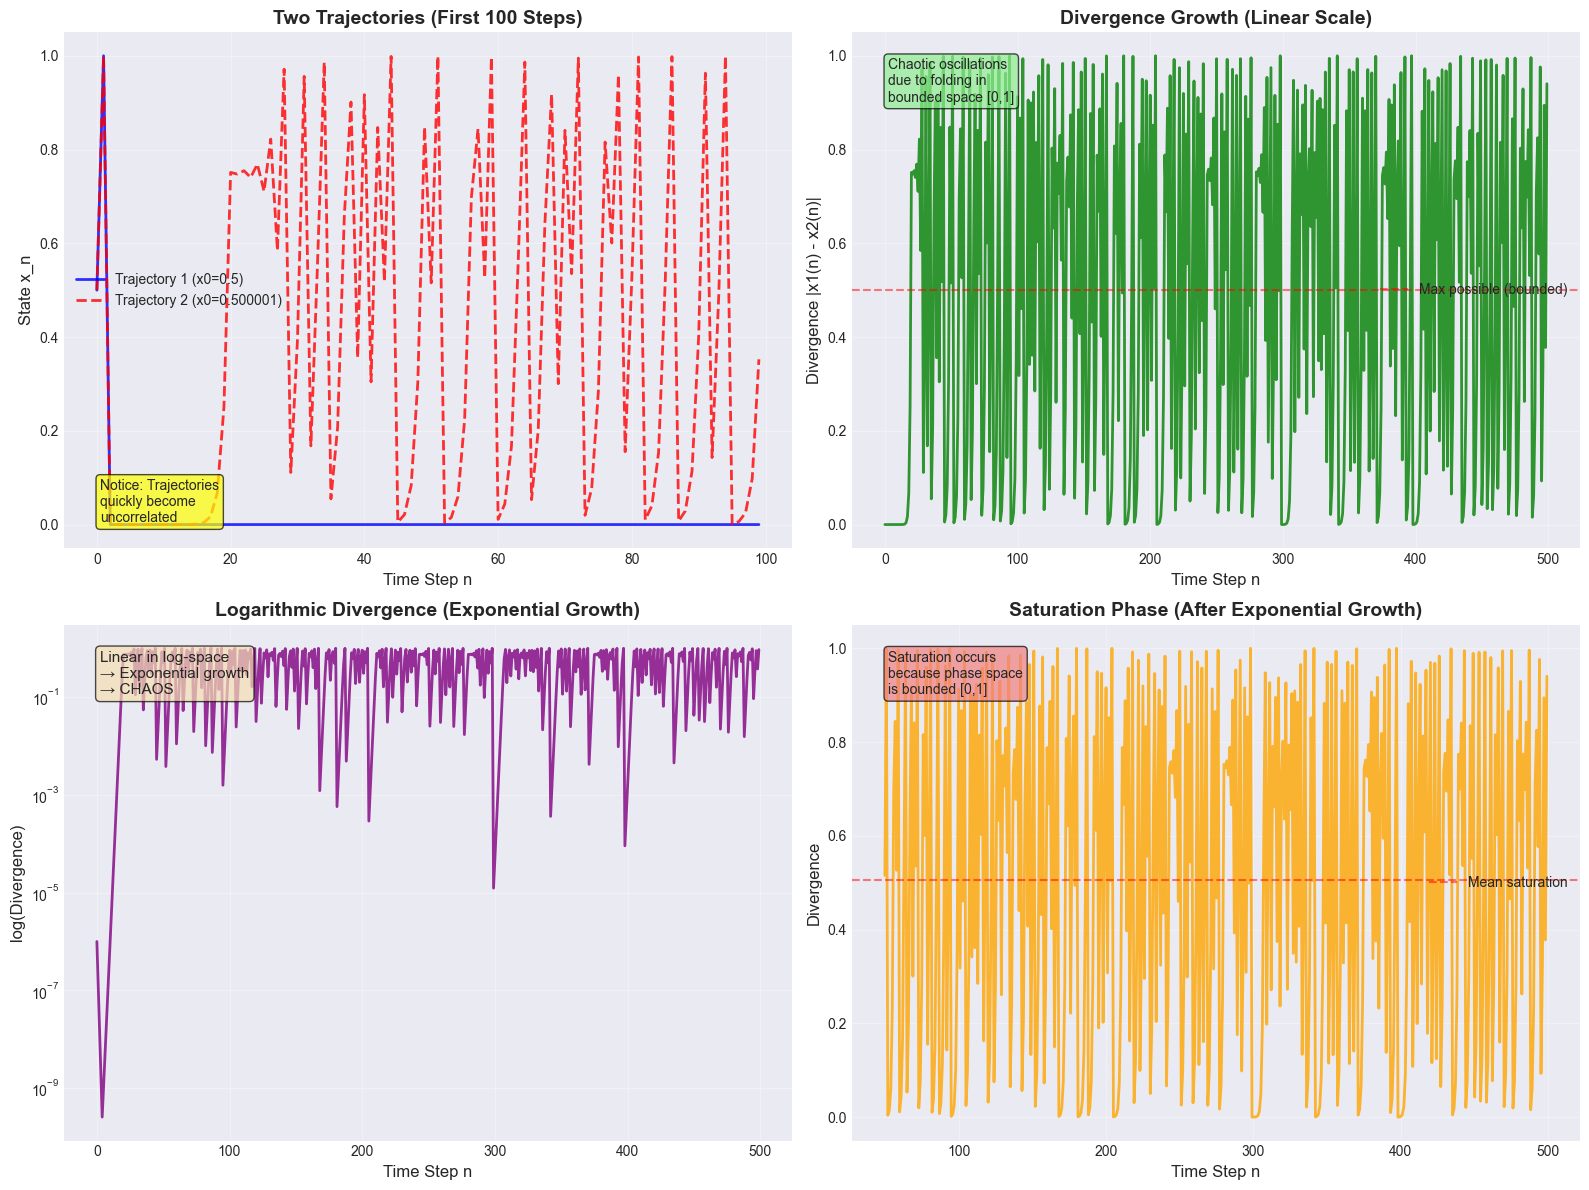

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Both trajectories (first 100 steps)
axes[0, 0].plot(time_steps[:100], traj1[:100], 'b-', label='Trajectory 1 (x0=0.5)', linewidth=2, alpha=0.8)
axes[0, 0].plot(time_steps[:100], traj2[:100], 'r--', label='Trajectory 2 (x0=0.500001)', linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Time Step n', fontsize=12)
axes[0, 0].set_ylabel('State x_n', fontsize=12)
axes[0, 0].set_title('Two Trajectories (First 100 Steps)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.05, 0.05, 'Notice: Trajectories\nquickly become\nuncorrelated',
                transform=axes[0, 0].transAxes, fontsize=10,
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Plot 2: Divergence over time (linear scale)
axes[0, 1].plot(time_steps, divergence, 'g-', linewidth=2, alpha=0.8)
axes[0, 1].set_xlabel('Time Step n', fontsize=12)
axes[0, 1].set_ylabel('Divergence |x1(n) - x2(n)|', fontsize=12)
axes[0, 1].set_title('Divergence Growth (Linear Scale)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Max possible (bounded)')
axes[0, 1].legend()
axes[0, 1].text(0.05, 0.95, 'Chaotic oscillations\ndue to folding in\nbounded space [0,1]',
                transform=axes[0, 1].transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

# Plot 3: Log divergence (shows exponential growth)
nonzero_idx = divergence > 1e-10
axes[1, 0].semilogy(time_steps[nonzero_idx], divergence[nonzero_idx], 'purple', linewidth=2, alpha=0.8)
axes[1, 0].set_xlabel('Time Step n', fontsize=12)
axes[1, 0].set_ylabel('log(Divergence)', fontsize=12)
axes[1, 0].set_title('Logarithmic Divergence (Exponential Growth)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].text(0.05, 0.95, 'Linear in log-space\n→ Exponential growth\n→ CHAOS',
                transform=axes[1, 0].transAxes, fontsize=11,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Plot 4: Saturation phase
axes[1, 1].plot(time_steps[50:], divergence[50:], 'orange', linewidth=2, alpha=0.8)
axes[1, 1].set_xlabel('Time Step n', fontsize=12)
axes[1, 1].set_ylabel('Divergence', fontsize=12)
axes[1, 1].set_title('Saturation Phase (After Exponential Growth)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=np.mean(divergence[200:]), color='red', linestyle='--', alpha=0.5, label='Mean saturation')
axes[1, 1].legend()
axes[1, 1].text(0.05, 0.95, 'Saturation occurs\nbecause phase space\nis bounded [0,1]',
                transform=axes[1, 1].transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

plt.tight_layout()
plt.savefig('logistic_map_divergence.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Load Text Generation Results

Now we load the results from our text generation experiment to compare with the logistic map.

In [9]:
def read_text_file(filepath: str) -> str:
    """Read text from file."""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()


def tokenize(text: str) -> list:
    """Tokenize text into words."""
    return text.split()


def calculate_text_divergence(tokens1, tokens2):
    """
    Calculate Levenshtein distance for growing prefixes.
    
    This is analogous to calculating divergence at each 'time step'
    in the logistic map, but here each step is one additional token.
    """
    max_length = min(len(tokens1), len(tokens2))
    k_values = []
    d_values = []
    
    for k in range(1, max_length + 1):
        prefix1 = ' '.join(tokens1[:k])
        prefix2 = ' '.join(tokens2[:k])
        distance = Levenshtein.distance(prefix1, prefix2)
        k_values.append(k)
        d_values.append(distance)
    
    return np.array(k_values), np.array(d_values)


print("="*70)
print("LOADING TEXT GENERATION RESULTS")
print("="*70)

try:
    # Load text files from data/ directory
    text1 = read_text_file('data/text1.txt')
    text2 = read_text_file('data/text2.txt')
    tokens1 = tokenize(text1)
    tokens2 = tokenize(text2)
    
    print(f"\nLoaded text files from data/ directory")
    print(f"  Text 1: {len(tokens1)} tokens")
    print(f"  Text 2: {len(tokens2)} tokens")
    
    # Calculate text divergence
    k_text, d_text = calculate_text_divergence(tokens1, tokens2)
    print(f"  Divergence calculated for {len(k_text)} token positions")
    
    # Calculate text Lyapunov exponent
    first_nonzero_text = next((i for i, d in enumerate(d_text) if d > 0), 1)
    lambda_text_eff = (1.0 / len(k_text)) * np.log(d_text[-1] / d_text[first_nonzero_text]) if d_text[first_nonzero_text] > 0 else 0
    
    print(f"\nText Generation Lyapunov Exponent:")
    print(f"  λ_eff = {lambda_text_eff:.4f}")
    print(f"\nLyapunov exponent → 0 indicates NON-CHAOTIC BEHAVIOR")
    print("="*70)
    
except FileNotFoundError as e:
    print(f"\nError: Could not find text files: {e}")
    print(f"  Skipping text comparison...")
    k_text = None
    d_text = None
    lambda_text_eff = None

LOADING TEXT GENERATION RESULTS

Loaded text files from data/ directory
  Text 1: 602 tokens
  Text 2: 504 tokens
  Divergence calculated for 504 token positions

Text Generation Lyapunov Exponent:
  λ_eff = 0.0121

Lyapunov exponent → 0 indicates NON-CHAOTIC BEHAVIOR


## 8. Direct Comparison: Logistic Map vs Text Generation

Now we create a side-by-side comparison showing the critical difference:

- **Logistic map**: Exponential divergence (chaos)
- **Text generation**: Linear divergence (not chaos)

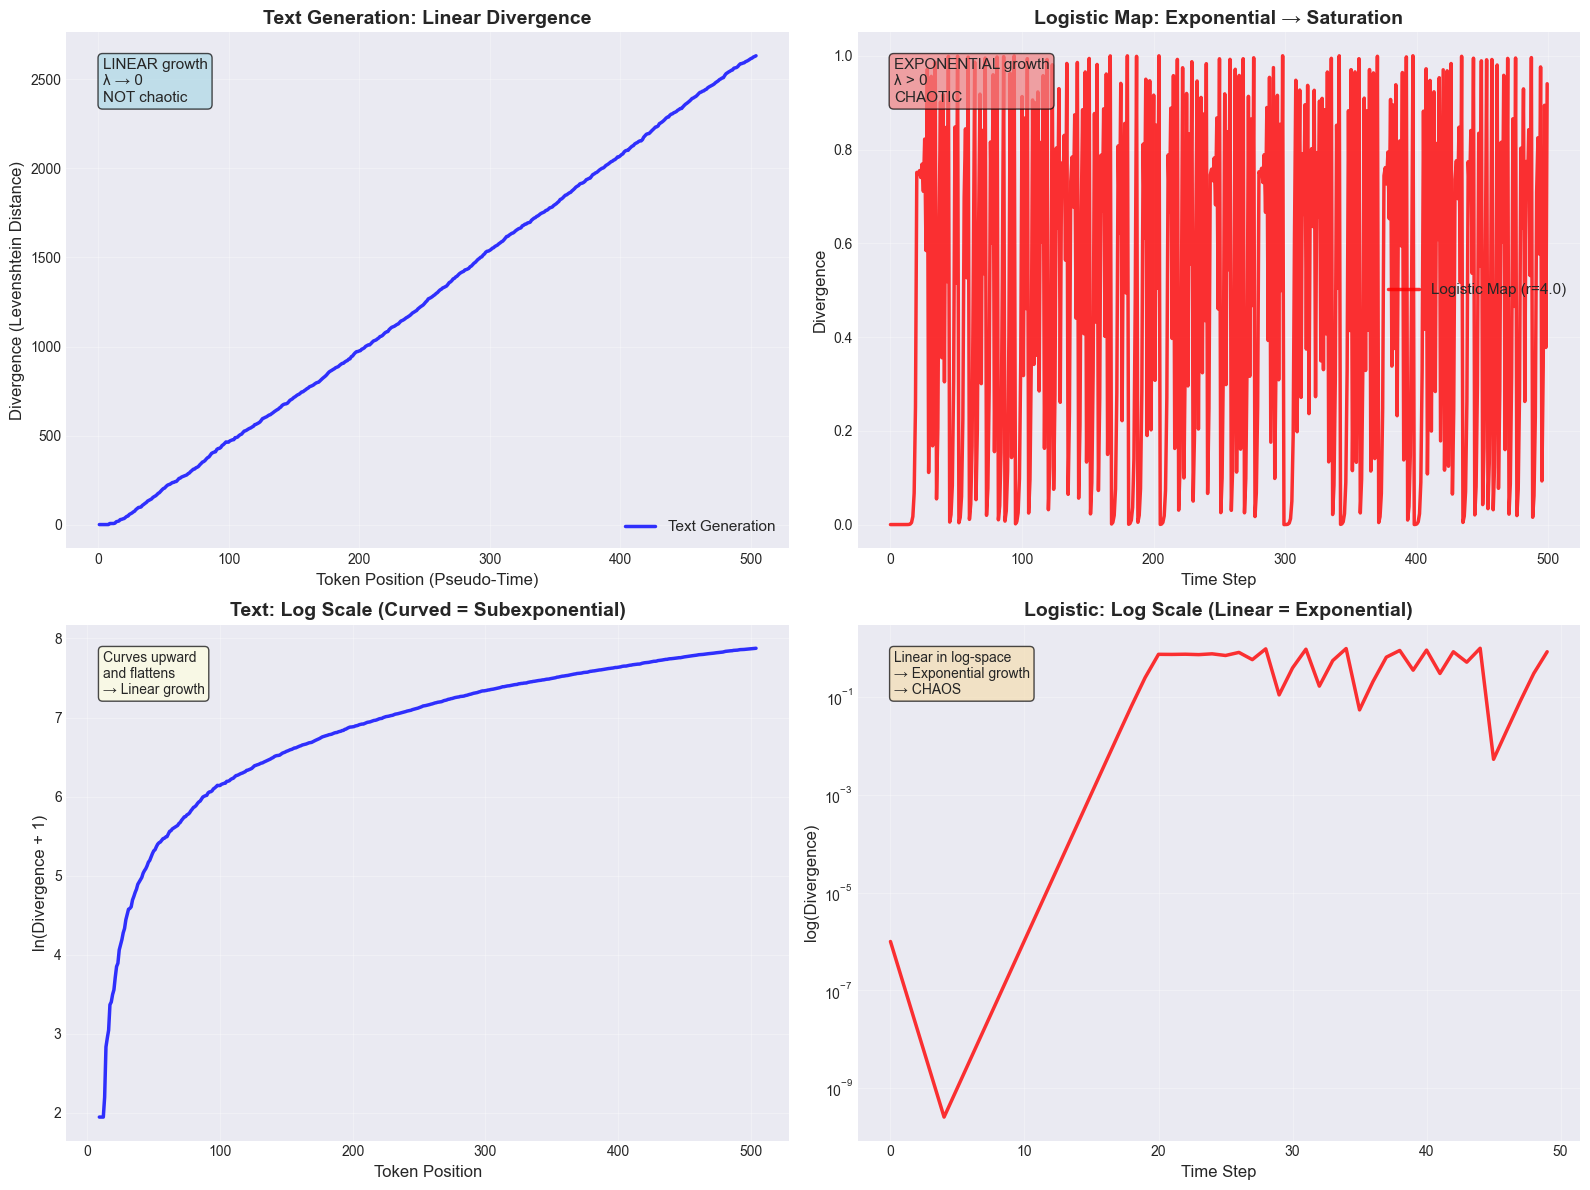

In [10]:
if k_text is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Text generation - Linear scale
    axes[0, 0].plot(k_text, d_text, 'b-', linewidth=2.5, label='Text Generation', alpha=0.8)
    axes[0, 0].set_xlabel('Token Position (Pseudo-Time)', fontsize=12)
    axes[0, 0].set_ylabel('Divergence (Levenshtein Distance)', fontsize=12)
    axes[0, 0].set_title('Text Generation: Linear Divergence', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].text(0.05, 0.95, 'LINEAR growth\nλ → 0\nNOT chaotic',
                    transform=axes[0, 0].transAxes, fontsize=11,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    # Plot 2: Logistic map - Linear scale
    axes[0, 1].plot(time_steps[:len(k_text)], divergence[:len(k_text)],
                    'r-', linewidth=2.5, label='Logistic Map (r=4.0)', alpha=0.8)
    axes[0, 1].set_xlabel('Time Step', fontsize=12)
    axes[0, 1].set_ylabel('Divergence', fontsize=12)
    axes[0, 1].set_title('Logistic Map: Exponential → Saturation', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].text(0.05, 0.95, 'EXPONENTIAL growth\nλ > 0\nCHAOTIC',
                    transform=axes[0, 1].transAxes, fontsize=11,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
    
    # Plot 3: Text - Log scale (shows subexponential)
    text_nonzero = d_text > 0
    axes[1, 0].plot(k_text[text_nonzero], np.log(d_text[text_nonzero] + 1), 'b-', linewidth=2.5, alpha=0.8)
    axes[1, 0].set_xlabel('Token Position', fontsize=12)
    axes[1, 0].set_ylabel('ln(Divergence + 1)', fontsize=12)
    axes[1, 0].set_title('Text: Log Scale (Curved = Subexponential)', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].text(0.05, 0.95, 'Curves upward\nand flattens\n→ Linear growth',
                    transform=axes[1, 0].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
    
    # Plot 4: Logistic - Log scale (shows exponential)
    logistic_nonzero = divergence > 1e-10
    axes[1, 1].semilogy(time_steps[:50][logistic_nonzero[:50]],
                        divergence[:50][logistic_nonzero[:50]],
                        'r-', linewidth=2.5, alpha=0.8)
    axes[1, 1].set_xlabel('Time Step', fontsize=12)
    axes[1, 1].set_ylabel('log(Divergence)', fontsize=12)
    axes[1, 1].set_title('Logistic: Log Scale (Linear = Exponential)', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].text(0.05, 0.95, 'Linear in log-space\n→ Exponential growth\n→ CHAOS',
                    transform=axes[1, 1].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    plt.tight_layout()
    plt.savefig('comparison_text_vs_logistic.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Skipping comparison plot (text files not loaded)")

## 9. Comparison Summary Table

A comprehensive comparison of the two systems:

In [12]:
print("\n" + "="*90)
print("COMPARISON SUMMARY: LOGISTIC MAP vs TEXT GENERATION")
print("="*90)
print()

properties = [
    'System Type',
    'Initial Perturbation',
    'Divergence Growth',
    'Lyapunov Exponent λ',
    'Phase Space',
    'Chaotic?',
    'Sensitive to IC?',
]

logistic_values = [
    'Classical dynamical system',
    f'{x0_2 - x0_1:.1e} ({(x0_2 - x0_1)/x0_1 * 100:.4f}%)',
    'Exponential → Saturation',
    f'{lambda_analytical:.4f} (POSITIVE)',
    'Bounded [0, 1]',
    '✓ YES',
    '✓ YES',
]

if lambda_text_eff is not None:
    text_values = [
        'Linguistic trajectory',
        '1 word change ("driven" → "governed")',
        'Linear (sustained)',
        f'{lambda_text_eff:.4f} (→ 0)',
        'Unbounded (infinite vocabulary)',
        '✗ NO',
        '✓ YES',
    ]
else:
    text_values = ['N/A'] * len(properties)

# Print formatted table
print(f"{'Property':<25} | {'Logistic Map (r=4.0)':<35} | {'Text Generation':<35}")
print("-" * 100)
for prop, log_val, text_val in zip(properties, logistic_values, text_values):
    print(f"{prop:<25} | {log_val:<35} | {text_val:<35}")

print("="*90)

# Save to CSV
with open('comparison_table.csv', 'w') as f:
    f.write("Property,Logistic Map (r=4.0),Text Generation (LLM)\n")
    for prop, log_val, text_val in zip(properties, logistic_values, text_values):
        log_val_clean = log_val.replace(',', ';')
        text_val_clean = text_val.replace(',', ';')
        f.write(f'"{prop}","{log_val_clean}","{text_val_clean}"\n')

print("\nSaved: comparison_table.csv")


COMPARISON SUMMARY: LOGISTIC MAP vs TEXT GENERATION

Property                  | Logistic Map (r=4.0)                | Text Generation                    
----------------------------------------------------------------------------------------------------
System Type               | Classical dynamical system          | Linguistic trajectory              
Initial Perturbation      | 1.0e-06 (0.0002%)                   | 1 word change ("driven" → "governed")
Divergence Growth         | Exponential → Saturation            | Linear (sustained)                 
Lyapunov Exponent λ       | 1.3863 (POSITIVE)                   | 0.0121 (→ 0)                       
Phase Space               | Bounded [0, 1]                      | Unbounded (infinite vocabulary)    
Chaotic?                  | ✓ YES                               | ✗ NO                               
Sensitive to IC?          | ✓ YES                               | ✓ YES                              

Saved: comparison_table.cs

## 10. Conclusions and Interpretation

### Key Findings

#### Similarities:

1. **Both are deterministic**: Same initial condition → same output
2. **Both show sensitivity to initial conditions**: Small changes lead to different trajectories
3. **Both exhibit divergence**: Trajectories separate over time

#### Critical Differences:

| Aspect | Logistic Map | Text Generation |
|--------|-------------|----------------|
| **Divergence type** | Exponential | Linear |
| **Lyapunov exponent** | λ ≈ 1.39 (constant, positive) | λ ≈ 0.01 (→ 0) |
| **Chaos** | ✓ Classical chaos | ✗ Not chaotic |
| **Phase space** | Bounded [0,1] | Unbounded |
| **Saturation** | Yes | No |

---

### Why is the logistic map chaotic but text generation is not?

1. **Bounded vs Unbounded Phase Space**:
   - Logistic map: Constrained to [0,1], forcing trajectories to "fold back" and interact nonlinearly
   - Text generation: Unlimited vocabulary space allows continuous expansion

2. **Nonlinear Amplification**:
   - Logistic map: Strong nonlinearity $x(1-x)$ exponentially amplifies perturbations
   - LLMs: While complex, token-to-token transitions are more stable

3. **Attractor Structure**:
   - Logistic map at r=4: Strange attractor with fractal structure
   - LLMs: Semantic/syntactic attractors guide generation along relatively stable paths

4. **Growth Mechanism**:
   - **Logistic map**: Perturbations grow exponentially until saturation
   - **Text generation**: Perturbations accumulate linearly (drift/random walk)

---

### Final Conclusion

**While text generation exhibits sensitivity to initial conditions** (changing one word leads to very different outputs), **it does NOT exhibit classical deterministic chaos** as defined by positive Lyapunov exponents and exponential divergence.

The divergence in text generation is better described as:
- **Semantic drift**: Gradual accumulation of differences
- **Branching without explosive separation**: Paths diverge but not exponentially
- **Stable instability**: Deterministic but not chaotic

### Implications

This finding has important practical implications:

1. **LLM Predictability**: More predictable than chaotic systems
2. **Alignment and Safety**: Small prompt changes → significant but not catastrophic differences
3. **Reproducibility**: LLM outputs are more stable than chaotic systems
4. **Control**: Easier to guide and constrain compared to truly chaotic systems

---